### Loading Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pyspark import SparkConf, SparkContext, SQLContext
conf = SparkConf().setAppName("AirBnB")
sc = SparkContext(conf=conf)
sql = SQLContext(sc)

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

import pyspark.sql.functions as Fn
import pyspark.sql.types as Tp

In [2]:
'''
Airbnb data for US from 

https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/
?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&refine.country=United+States


LOADING THIS DIRECTLY AS A DATAFRAME WAS CAUSING COLUMNS TO SHIFT, SO LOADING THIS FILE AS RDD FIRST

'''
air =sc.textFile('/Users/mannu/Desktop/Big Data/Group Project/airbnb-listings.csv')
air.take(2)

['ID;Listing Url;Scrape ID;Last Scraped;Name;Summary;Space;Description;Experiences Offered;Neighborhood Overview;Notes;Transit;Access;Interaction;House Rules;Thumbnail Url;Medium Url;Picture Url;XL Picture Url;Host ID;Host URL;Host Name;Host Since;Host Location;Host About;Host Response Time;Host Response Rate;Host Acceptance Rate;Host Thumbnail Url;Host Picture Url;Host Neighbourhood;Host Listings Count;Host Total Listings Count;Host Verifications;Street;Neighbourhood;Neighbourhood Cleansed;Neighbourhood Group Cleansed;City;State;Zipcode;Market;Smart Location;Country Code;Country;Latitude;Longitude;Property Type;Room Type;Accommodates;Bathrooms;Bedrooms;Beds;Bed Type;Amenities;Square Feet;Price;Weekly Price;Monthly Price;Security Deposit;Cleaning Fee;Guests Included;Extra People;Minimum Nights;Maximum Nights;Calendar Updated;Has Availability;Availability 30;Availability 60;Availability 90;Availability 365;Calendar last Scraped;Number of Reviews;First Review;Last Review;Review Scores Ra

In [3]:
header = air.first()
air_split = air.filter(lambda r: r!=header).map(lambda r: r.lower().split(';'))
cols = [c.replace(' ', '_') for c in header.lower().split(';')]
cols

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee

In [4]:
print("Initial file has",air_split.count(),"rows and",len(cols),"columns")

Initial file has 276682 rows and 89 columns


### Creating DataFrame

In [5]:
air_actual = air_split.filter(lambda l: len(l)==len(cols))
print("After splitting all rows into 89 columns and filtering out rows which had more than 89 columns,")
print("we now have",air_actual.count(), "rows and",len(cols),"columns")

#only 32% rows remain

After splitting all rows into 89 columns and filtering out rows which had more than 89 columns,
we now have 88022 rows and 89 columns


In [6]:
air_df = sql.createDataFrame(air_actual,cols)
air_df.show(1,False)

+-------+------------------------------------+--------------+------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
#creating a function for shape of df
def shape(df):
    print("Shape of dataframe is {0} x {1}".format(df.count(),len(df.columns)))
    
shape(air_df) 

Shape of dataframe is 88022 x 89


In [8]:
#Since 'Price' is our Target variable dropping rows with no price
air_df = air_df.dropna(subset=['price'])
shape(air_df)

Shape of dataframe is 88022 x 89


In [9]:
import string
d = string.digits + '.'

def extract_number(v):
    z = ''
    for ch in v:
        if ch in d:
            z+=ch
    try:
        return float(z)
    except:
        return 0
    
numPrice = Fn.udf(lambda v: extract_number(v), Tp.FloatType())
air_df = air_df.withColumn("price", numPrice(air_df.price))
shape(air_df)

Shape of dataframe is 88022 x 89


In [10]:
#Also, no negative price
air_df = air_df.where(Fn.col('price')>0)
shape(air_df) 

Shape of dataframe is 86552 x 89


### Selecting Columns

In [11]:
#Dropping ID and Url columns
id_url = [k for k in air_df.columns if 'id' in k or 'url' in k]
print(id_url)

air_select = air_df.drop(*[k for k in air_df.columns if 'id' in k or 'url' in k])
shape(air_select)

['id', 'listing_url', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url']
Shape of dataframe is 86552 x 78


In [12]:
#Since the dataframe was converted from an RDD after splitting the string,
#there wont be any null values but empty '' values

#Creating a function to see number of empty cells per column
def empty(df):
    return df.select([Fn.count(Fn.when(Fn.col(c)=="", c)).alias(c) for c in df.columns]) \
        .toPandas().to_dict('records')[0]

empty(air_select)

{'last_scraped': 0,
 'name': 40,
 'summary': 2321,
 'space': 30717,
 'description': 38,
 'experiences_offered': 0,
 'neighborhood_overview': 38785,
 'notes': 54802,
 'transit': 36873,
 'access': 39835,
 'interaction': 42167,
 'house_rules': 33888,
 'host_name': 256,
 'host_since': 256,
 'host_location': 776,
 'host_about': 42474,
 'host_response_time': 23090,
 'host_response_rate': 23090,
 'host_acceptance_rate': 77324,
 'host_neighbourhood': 15653,
 'host_listings_count': 256,
 'host_total_listings_count': 256,
 'host_verifications': 57,
 'street': 0,
 'neighbourhood': 18505,
 'neighbourhood_cleansed': 0,
 'neighbourhood_group_cleansed': 57901,
 'city': 43,
 'state': 3,
 'zipcode': 1243,
 'market': 766,
 'smart_location': 1,
 'country_code': 0,
 'country': 0,
 'latitude': 0,
 'longitude': 0,
 'property_type': 3,
 'room_type': 0,
 'accommodates': 44,
 'bathrooms': 263,
 'bedrooms': 94,
 'beds': 172,
 'bed_type': 0,
 'amenities': 959,
 'square_feet': 85557,
 'price': 0,
 'weekly_price':

In [13]:
#Dropping columns with more than 50% None values.
d = empty(air_select)
thresh = air_select.count()/2 #43276
air_select = air_select.drop(*[k for k in d.keys() if d[k]>thresh])
shape(air_select) #10 columns dropped

Shape of dataframe is 86552 x 68


In [14]:
air_select.printSchema() #all strings except price

root
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_listings_count: string (nullable = true)
 |-- host_total_listings_count: string (nullable = true)
 |-- host_verifications: string (nullable = true)
 |-- street: string (nullable = true)
 |-- neighbou

In [15]:
#Lets see distinct values for each column
air_select.agg(*(Fn.countDistinct(Fn.col(c)).alias(c) for c in air_select.columns)).toPandas().T

,0
last_scraped,20
name,84248
summary,80930
space,53734
description,84756
experiences_offered,1
neighborhood_overview,43627
transit,45447
access,42059
interaction,39815


In [16]:
#dropping last_scraped for its insignificance
#dropping experiences for no variability
#dropping host_name for its insignificance
#dropping host_location, host_neighborhood, street, neighborhood, neighbourhood_cleansed, city, smart_location,
#     country_code, country, latitude, longitude, geolocation and keeping just state and zipcode
#dropping calendar_updated, calendar_last_scraped for their insignificance
air_select = air_select.drop(*['last_scraped','experiences_offered','host_name','host_neighbourhood',\
                               'host_location','street','neighbourhood','neighbourhood_cleansed','city',\
                               'smart_location','country','country_code','latitude','longitude','geolocation',\
                               'calendar_updated','calendar_last_scraped'])
shape(air_select)

Shape of dataframe is 86552 x 51


In [17]:
#Segregating cols on types
text_cols = ['name','summary','space','description','neighborhood_overview','transit','access',\
             'interaction','house_rules','host_about','host_verifications','market','amenities','features']
date_cols = ['host_since','first_review','last_review']
cat_cols = ['host_response_time','state','zipcode','property_type','room_type','bed_type','cancellation_policy']
int_cols = ['host_listings_count', 'host_total_listings_count',\
            'accommodates','bedrooms','beds','cleaning_fee',\
            'guests_included','extra_people','minimum_nights','maximum_nights',\
            'availability_30','availability_60','availability_90','availability_365',\
            'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',\
            'review_scores_checkin','review_scores_communication','review_scores_location',\
            'review_scores_value','calculated_host_listings_count']
float_cols = ['host_response_rate','bathrooms','reviews_per_month']

for col_name in date_cols:
    air_select = air_select.withColumn(col_name, Fn.col(col_name).cast(Tp.DateType()))

for col_name in int_cols:
    air_select = air_select.withColumn(col_name, Fn.col(col_name).cast(Tp.IntegerType()))
    
for col_name in float_cols:
    air_select = air_select.withColumn(col_name, Fn.col(col_name).cast(Tp.FloatType()))

air_select.printSchema()

root
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: float (nullable = true)
 |-- host_listings_count: integer (nullable = true)
 |-- host_total_listings_count: integer (nullable = true)
 |-- host_verifications: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- market: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms: float (nullable = true

In [18]:
def nans(df,cols):
    return df.select([Fn.count(Fn.when(Fn.isnan(c) | Fn.col(c).isNull(), c)).alias(c) for c in cols]) \
        .toPandas().to_dict('records')[0]

d = nans(air_select,int_cols+float_cols)
print(d)
thresh = air_select.count()/2 #43276
air_select = air_select.drop(*[k for k in d.keys() if d[k]>thresh])
shape(air_select)

{'host_listings_count': 256, 'host_total_listings_count': 256, 'accommodates': 44, 'bedrooms': 94, 'beds': 172, 'cleaning_fee': 26655, 'guests_included': 0, 'extra_people': 0, 'minimum_nights': 0, 'maximum_nights': 0, 'availability_30': 0, 'availability_60': 0, 'availability_90': 0, 'availability_365': 0, 'number_of_reviews': 0, 'review_scores_rating': 23897, 'review_scores_accuracy': 24053, 'review_scores_cleanliness': 24021, 'review_scores_checkin': 24112, 'review_scores_communication': 24019, 'review_scores_location': 24113, 'review_scores_value': 24134, 'calculated_host_listings_count': 0, 'host_response_rate': 23090, 'bathrooms': 263, 'reviews_per_month': 22734}
Shape of dataframe is 86552 x 51


### Imputing Values

In [19]:
#Imputing values
air_imputed = air_select
for c in text_cols+cat_cols:
    air_imputed = air_imputed.withColumn(c, Fn.when(Fn.trim(Fn.col(c))=="","unknown_"+c).otherwise(Fn.col(c)))
empty(air_imputed)

{'name': 0,
 'summary': 0,
 'space': 0,
 'description': 0,
 'neighborhood_overview': 0,
 'transit': 0,
 'access': 0,
 'interaction': 0,
 'house_rules': 0,
 'host_since': 0,
 'host_about': 0,
 'host_response_time': 0,
 'host_response_rate': 0,
 'host_listings_count': 0,
 'host_total_listings_count': 0,
 'host_verifications': 0,
 'state': 0,
 'zipcode': 0,
 'market': 0,
 'property_type': 0,
 'room_type': 0,
 'accommodates': 0,
 'bathrooms': 0,
 'bedrooms': 0,
 'beds': 0,
 'bed_type': 0,
 'amenities': 0,
 'price': 0,
 'cleaning_fee': 0,
 'guests_included': 0,
 'extra_people': 0,
 'minimum_nights': 0,
 'maximum_nights': 0,
 'availability_30': 0,
 'availability_60': 0,
 'availability_90': 0,
 'availability_365': 0,
 'number_of_reviews': 0,
 'first_review': 0,
 'last_review': 0,
 'review_scores_rating': 0,
 'review_scores_accuracy': 0,
 'review_scores_cleanliness': 0,
 'review_scores_checkin': 0,
 'review_scores_communication': 0,
 'review_scores_location': 0,
 'review_scores_value': 0,
 'ca

In [20]:
#As the average of columns are susceptible to outliers, imputing with median instead
cols = int_cols+float_cols
medians = {}
for col in cols:
    medians[col] = air_imputed.approxQuantile(col, [0.5], 0.05)[0]
air_imputed = air_imputed.fillna(medians)
nans(air_imputed,int_cols+float_cols)

{'host_listings_count': 0,
 'host_total_listings_count': 0,
 'accommodates': 0,
 'bedrooms': 0,
 'beds': 0,
 'cleaning_fee': 0,
 'guests_included': 0,
 'extra_people': 0,
 'minimum_nights': 0,
 'maximum_nights': 0,
 'availability_30': 0,
 'availability_60': 0,
 'availability_90': 0,
 'availability_365': 0,
 'number_of_reviews': 0,
 'review_scores_rating': 0,
 'review_scores_accuracy': 0,
 'review_scores_cleanliness': 0,
 'review_scores_checkin': 0,
 'review_scores_communication': 0,
 'review_scores_location': 0,
 'review_scores_value': 0,
 'calculated_host_listings_count': 0,
 'host_response_rate': 0,
 'bathrooms': 0,
 'reviews_per_month': 0}

### Handling outliers

In [21]:
air_imputed.select(int_cols + float_cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
host_listings_count,86552,6.699579443571494,50.126803019107044,0,1026
host_total_listings_count,86552,6.699579443571494,50.126803019107044,0,1026
accommodates,86552,3.27764811904982,2.198775993295235,1,16
bedrooms,86552,1.3111770958498936,0.8738270421766702,0,10
beds,86552,1.7520565671503836,1.2774609332072455,0,16
cleaning_fee,86552,62.9905605878547,44.83600813950013,0,850
guests_included,86552,1.5921064793418984,1.330684644261479,0,16
extra_people,86552,11.699775857288104,21.68255921843313,0,500
minimum_nights,86552,3.283517423052038,10.915638173184897,1,1250


In [22]:
#There as some outliers especially in 'maximum_nights', lets cap them

bounds = {}
air_bounded = air_imputed
cols = int_cols + float_cols
for c in cols: 
    quantiles = air_bounded.approxQuantile(c, [0.25, 0.75], 0.005)
    IQR = quantiles[1] - quantiles[0]
    bounds[c] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
    air_bounded = air_bounded.withColumn(c, Fn.when(Fn.col(c)<bounds[c][0],bounds[c][0]). \
                                         when(Fn.col(c)>bounds[c][1],bounds[c][1]).otherwise(Fn.col(c)))
for col_name in int_cols:
    air_bounded = air_bounded.withColumn(col_name, Fn.col(col_name).cast(Tp.IntegerType()))

air_bounded.select(int_cols + float_cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
host_listings_count,86552,1.5650822626860152,0.8126721027581213,0,3
host_total_listings_count,86552,1.5650822626860152,0.8126721027581213,0,3
accommodates,86552,3.1310195027266845,1.7442989459790361,1,7
bedrooms,86552,1.272656899898327,0.7521968904331658,0,3
beds,86552,1.5825977447083834,0.7725871803664943,0,3
cleaning_fee,86552,58.88274101118403,31.402910592992523,0,127
guests_included,86552,1.3945142804325723,0.6969640330269365,0,3
extra_people,86552,10.34908494315556,15.403927664127966,0,50
minimum_nights,86552,2.2744015158517423,1.5403173704234416,1,6


In [23]:
#Some columns have no variability left, dropping those columns
cols = ['host_response_rate','bathrooms','review_scores_accuracy', \
        'review_scores_checkin','review_scores_communication','review_scores_location']
air_bounded = air_bounded.drop(*cols)
shape(air_bounded) 

Shape of dataframe is 86552 x 45


### Column Transformations

In [24]:
#Rather than date columns, we will create new column for each having days since that date
def date_to_num_days(df, cols):
    df = df.withColumn("today", Fn.current_date())
    for c in cols:
        df = df.withColumn("num_days_"+c, Fn.datediff('today',Fn.col(c))) 
    return df.drop(*cols).drop("today")

air_transformed = date_to_num_days(air_bounded,date_cols)
#checking nans now,
nans(air_transformed,air_transformed.columns)

{'name': 0,
 'summary': 0,
 'space': 0,
 'description': 0,
 'neighborhood_overview': 0,
 'transit': 0,
 'access': 0,
 'interaction': 0,
 'house_rules': 0,
 'host_about': 0,
 'host_response_time': 0,
 'host_listings_count': 0,
 'host_total_listings_count': 0,
 'host_verifications': 0,
 'state': 0,
 'zipcode': 0,
 'market': 0,
 'property_type': 0,
 'room_type': 0,
 'accommodates': 0,
 'bedrooms': 0,
 'beds': 0,
 'bed_type': 0,
 'amenities': 0,
 'price': 0,
 'cleaning_fee': 0,
 'guests_included': 0,
 'extra_people': 0,
 'minimum_nights': 0,
 'maximum_nights': 0,
 'availability_30': 0,
 'availability_60': 0,
 'availability_90': 0,
 'availability_365': 0,
 'number_of_reviews': 0,
 'review_scores_rating': 0,
 'review_scores_cleanliness': 0,
 'review_scores_value': 0,
 'cancellation_policy': 0,
 'calculated_host_listings_count': 0,
 'reviews_per_month': 0,
 'features': 0,
 'num_days_host_since': 256,
 'num_days_first_review': 22734,
 'num_days_last_review': 22633}

In [25]:
#imputing the new columns NaNs with -1
air_transformed = air_transformed.na.fill(-1)
shape(air_transformed)

Shape of dataframe is 86552 x 45


In [26]:
#Lets take a look at our label column i.e. price

label_histogram = air_transformed.select('price').rdd.flatMap(lambda x: x).histogram(11)
pd.DataFrame(list(zip(*label_histogram)), columns=['bin', 'frequency']).set_index('bin').plot(kind='bar')


Regression's underlying assumption is that the dependent variable should have a normal distribution. However from above, our dependent variable. doesnt follow that. So we need to transform the variable in order to achieve it. Let's take a log of price and see the distribution.

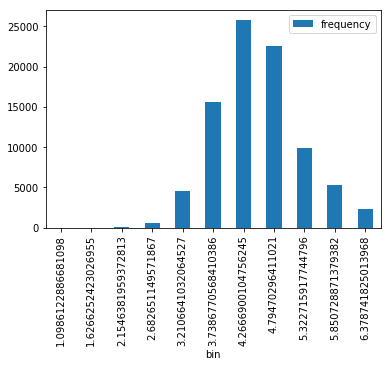

In [27]:
label_histogram = air_transformed.select(Fn.log('price')).rdd.flatMap(lambda x: x).histogram(11)
pd.DataFrame(list(zip(*label_histogram)), columns=['bin', 'frequency']).set_index('bin').plot(kind='bar')


In [28]:
#A bit negatively skewed but this is still close to normal distribution, 
#so we create our label with Log(price)
air_transformed = air_transformed.withColumn('label', Fn.log('price'))
shape(air_transformed) 

#Note at this point we have 2 columns which are not features

Shape of dataframe is 86552 x 46


### Correlation Analysis

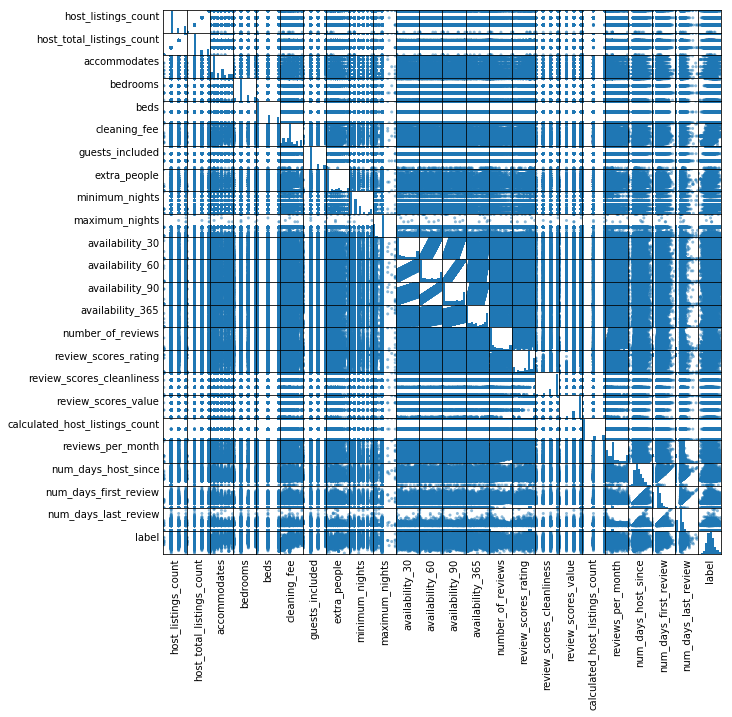

In [29]:
#Easiest way to see if there are some relationships among independent variables is to make Scatter Plots

import matplotlib.pyplot as plt

numeric_cols = [t[0] for t in air_transformed.dtypes if t[1] != 'string' and t[0] != 'price']
sampled_data = air_transformed.select(numeric_cols).sample(False, 0.1, 1).toPandas()
axs = pd.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
    
#SINCE THIS IS NOT SO EASY TO READ, 
#WE WILL MAKE A CORRELATION HEATMAP TO SEE THE RELATIONSHIPS, IF ANY, AMONG THE INDEPENDENT VARIABLES

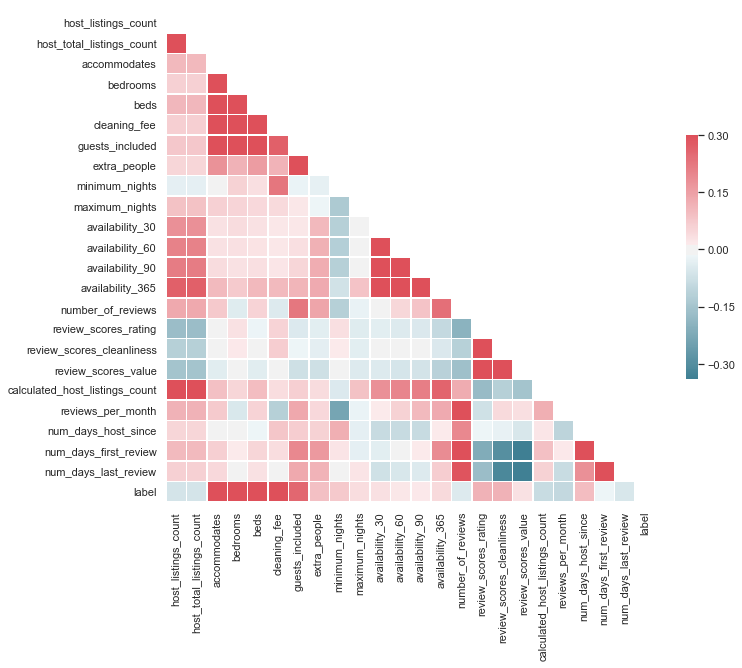

In [30]:
import seaborn as sns

def heatcorr(df, cols):
    sampled_data = df.select(cols).sample(False, 0.1,1).toPandas()
    sns.set(style="white")
    corr = sampled_data.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

heatcorr(air_transformed, numeric_cols)
#much better

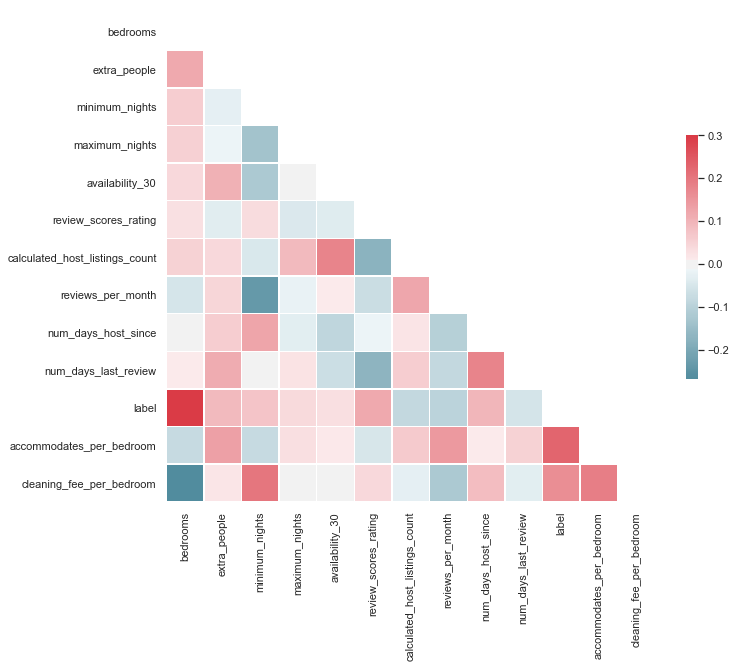

In [31]:
#Dropping 'host_total_listings_count','host_listings_count' for their correlation with 'calculated_host_listings_count'
#Adding accommodates_per_bedroom and dropping accommodates
#Dropping 'beds' because of its correlation with bedrooms
#Adding cleaning_fee_per_bedroom and dropping cleaning_fee
#Dropping 'guests_included' for its correlation with bedrooms
#Dropping 'availability_60','availability_90','availability_365', high correlation with availability_30
#Dropping 'number_of_reviews' for its correlation with 'reviews_per_month'
#Keeping 'review_scores_rating' and Dropping 'review_scores_value'
#Dropping 'num_days_first_review' for its correlation with other num_days columns
air_reduced = air_transformed
air_reduced = air_reduced.drop(*['host_total_listings_count','host_listings_count']) \
    .withColumn("accommodates_per_bedroom", \
                Fn.when(Fn.isnull(air_transformed.accommodates/air_transformed.bedrooms), \
                        air_transformed.accommodates) \
                .otherwise(air_transformed.accommodates/air_transformed.bedrooms)) \
    .drop(*['accommodates','beds']) \
    .withColumn("cleaning_fee_per_bedroom", \
                Fn.when(Fn.isnull(air_transformed.cleaning_fee/air_transformed.bedrooms), \
                        air_transformed.cleaning_fee) \
                .otherwise(air_transformed.cleaning_fee/air_transformed.bedrooms)) \
    .drop(*['cleaning_fee','guests_included','availability_60','availability_90','availability_365', \
            'number_of_reviews','review_scores_cleanliness','review_scores_value','num_days_first_review'])

numeric_cols = [c[0] for c in air_reduced.dtypes if c[1]!='string' and c[0] != 'price']
heatcorr(air_reduced, numeric_cols) 

#there are still correlations of ~0.3 but we will proceed as of now

### Handling descriptive text columns

In [32]:
#lets see the sample
air_reduced.select(text_cols).sample(False, 0.0001,1).toPandas()

,name,summary,space,description,neighborhood_overview,transit,access,interaction,house_rules,host_about,host_verifications,market,amenities,features
0,enjoy some peace and quiet,comfortable room in private home located in th...,private room with locking door. large shared b...,comfortable room in private home located in th...,valley glen is on the northern border of sherm...,parking is available in front of the house on ...,"bedroom, main bathroom, living room, kitchen f...",i am happy to interact or be a chameleon. gues...,"- no loud music, television or loud phone conv...",i am a design therapist and awesome cook.,"email,phone,linkedin,kba",los angeles,"tv,wireless internet,air conditioning,pool,kit...","host has profile pic,host identity verified,is..."
1,gorgeous home - 15 minutes to essence fest!,enjoy a beautiful respite right near the missi...,this is a spacious home with all the modern co...,enjoy a beautiful respite right near the missi...,this neighborhood was one that was hit hardest...,the house is two blocks away from a main stree...,as a guest you'll have access to the living ro...,if you need help with how to get downtown with...,- no shoes in the house. - if you bring a dog...,"i am fun loving, artistic type-musician and pa...","email,phone,facebook,reviews",new orleans,"wireless internet,air conditioning,kitchen,fre...","host has profile pic,is location exact,require..."
2,2 bedrooms friendly apartment,"walking distance: korea house, grocery, restau...",unknown_space,"walking distance: korea house, grocery, restau...",unknown_neighborhood_overview,unknown_transit,unknown_access,unknown_interaction,unknown_house_rules,"hey, i'm saleh i would like to provide my plac...","email,phone,reviews",nashville,"tv,internet,wireless internet,air conditioning...","host has profile pic,is location exact"
3,historic hollywood bowl hideaway,unknown_summary,"built in the 1920's for silent film actors, th...","built in the 1920's for silent film actors, th...",unknown_neighborhood_overview,unknown_transit,unknown_access,unknown_interaction,"please be respectful of the neighbors, and the...",i'm a creative in the entertainment industry a...,"email,phone,reviews,kba",los angeles,"tv,internet,wireless internet,kitchen,free par...","host has profile pic,host identity verified,is..."
4,cozy room in uws,i have a cute & cozy room available when eithe...,it's a cozy ground floor duplex apartment with...,i have a cute & cozy room available when eithe...,my neighborhood is very close to the columbia ...,the apartment is just a 7 min walk away to cat...,"you will have access to the living room, kitch...",we are renting one room out when we are travel...,please don't invite other people to our apartm...,"i am a very friendly german girl, work in fina...","email,phone,reviews,jumio,government_id,work_e...",new york,"tv,cable tv,internet,wireless internet,air con...","host has profile pic,host identity verified,is..."
5,park slope private room and bath,unknown_summary,brand new just remodeled private room in park ...,brand new just remodeled private room in park ...,"the bars and cafes, the beautiful prospect pa...","yes, two train stations are near by. the f, ...",kitchen,unknown_interaction,"no house rules, building and neighborhood is ...",scarf designer based in brooklyn.,"email,phone,facebook,reviews,kba",new york,"tv,wireless internet,air conditioning,kitchen,...","host has profile pic,host identity verified,is..."
6,charming crown point beach bungalow,"our bungalow is 2 blocks from mission bay, 3 b...",unknown_space,"our bungalow is 2 blocks from mission bay, 3 b...",unknown_neighborhood_overview,unknown_transit,unknown_access,unknown_interaction,unknown_house_rules,unknown_host_about,"email,phone,reviews,jumio",san diego,"tv,cable tv,internet,wireless internet,air con...","host is superhost,host has profile pic,host id..."
7,cozy 2b 1b home 10 blocks to beach,"yes, this is the one you've been looking for. ...",the entrance to the hom

In [33]:
#Rather than 14 text columns, adding their respective wordcount columns
#This will give a sense of how price depends on number of words in a descriptive section

#Another thing we can add is the sentiment of these texts

#### NOTE #### 
#3 columns (host_verifications,amenities,features) are comma separated lists
#Each unique value in the list of these columns will be converted to separate columns
#the new columns will be binary indicating presence of that value in the list

comma_cols = ['host_verifications','amenities','features']
space_cols = list(set(text_cols) - set(comma_cols))

def wordcount(df, cols):
    for c in cols:
        df = df.withColumn('wc_'+c, Fn.size(Fn.split(Fn.col(c), ' ')))
    return df

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment(s):
    return sia.polarity_scores(s)['compound']

sentiment = Fn.udf(lambda t: get_sentiment(t), Tp.FloatType())

def sentiments(df, cols):
    for c in cols:
        df = df.withColumn('sentiment_'+c, sentiment(Fn.col(c)))
    return df.drop(*cols)

def feature_cols(df, cols):
    for col in cols:
        vals = sorted(list(df.select(Fn.explode(Fn.split(Fn.col(col), ','))).distinct().toPandas()['col']))
        for val in vals:
            df = df.withColumn(val.replace(' ','_'), Fn.when(Fn.col(col).like('%'+val+'%'), 1).otherwise(0))
    return df.drop(*cols)

air_expanded = wordcount(air_reduced, space_cols)
air_expanded = sentiments(air_expanded, space_cols)
air_expanded = feature_cols(air_expanded, comma_cols)
shape(air_expanded)


Shape of dataframe is 86552 x 184


In [34]:
#lets see the sample again
air_expanded.sample(False, 0.0001,1).toPandas()

,host_response_time,state,zipcode,property_type,room_type,bedrooms,bed_type,price,extra_people,minimum_nights,maximum_nights,availability_30,review_scores_rating,cancellation_policy,calculated_host_listings_count,reviews_per_month,num_days_host_since,num_days_last_review,label,accommodates_per_bedroom,cleaning_fee_per_bedroom,wc_space,wc_name,wc_house_rules,wc_access,wc_market,wc_interaction,wc_summary,wc_description,wc_neighborhood_overview,wc_host_about,wc_transit,sentiment_space,sentiment_name,sentiment_house_rules,sentiment_access,sentiment_market,sentiment_interaction,sentiment_summary,sentiment_description,sentiment_neighborhood_overview,sentiment_host_about,sentiment_transit,amex,email,facebook,google,government_id,identity_manual,jumio,kba,linkedin,manual_offline,manual_online,none,offline_government_id,phone,photographer,reviews,selfie,sent_id,sesame,sesame_offline,unknown_host_verifications,weibo,work_email,24-hour_check-in,accessible-height_bed,accessible-height_toilet,air_conditioning,baby_bath,baby_monitor,babysitter_recommendations,bathtub,bbq_grill,beach_essentials,bed_linens,breakfast,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,cat(s),changing_table,children’s_books_and_toys,children’s_dinnerware,cleaning_before_checkout,coffee_maker,cooking_basics,crib,disabled_parking_spot,dishes_and_silverware,dishwasher,dog(s),doorman,doorman_entry,dryer,elevator_in_building,essentials,ethernet_connection,ev_charger,extra_pillows_and_blankets,family/kid_friendly,fire_extinguisher,fireplace_guards,firm_matress,firm_mattress,first_aid_kit,flat_smooth_pathway_to_front_door,free_parking_on_premises,free_parking_on_street,game_console,garden_or_backyard,grab-rails_for_shower_and_toilet,gym,hair_dryer,hangers,heating,high_chair,hot_tub,hot_water,indoor_fireplace,internet,iron,keypad,kitchen,laptop_friendly_workspace,lock_on_bedroom_door,lockbox,long_term_stays_allowed,luggage_dropoff_allowed,microwave,other_pet(s),outlet_covers,oven,pack_’n_play/travel_crib,paid_parking_off_premises,path_to_entrance_lit_at_night,patio_or_balcony,pets_allowed,pets_live_on_this_property,pocket_wifi,pool,private_bathroom,private_entrance,private_living_room,refrigerator,room-darkening_shades,safety_card,self_check-in,shampoo,single_level_home,smart_lock,smartlock,smoke_detector,smoking_allowed,stair_gates,step-free_access,stove,suitable_for_events,table_corner_guards,translation_missing:_en.hosting_amenity_49,translation_missing:_en.hosting_amenity_50,tub_with_shower_bench,tv,unknown_amenities,washer,washer_/_dryer,waterfront,wheelchair_accessible,wide_clearance_to_bed,wide_clearance_to_shower_and_toilet,wide_doorway,wide_hallway_clearance,window_guards,wireless_internet,host_has_profile_pic,host_identity_verified,host_is_superhost,instant_bookable,is_location_exact,require_guest_phone_verification,require_guest_profile_picture,requires_license,unknown_features
0,unknown_host_response_time,ca,91401,house,private room,1,real bed,100.0,0,1,1125,29,97,moderate,1,1.12,1293,-1,4.605170,1.0,55.0,34,5,42,47,2,39,78,169,57,8,36,0.9287,0.7717,-0.7717,0.3291,0.0,0.8990,0.9700,0.9776,0.8998,0.6249,-0.3612,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0
1,within a day,la,70117,house,private room,1,real bed,55.0,50,4,14,29,100,strict,2,0.34,2481,786,4.007333,2.0,55.0,42,8,97,40,2,19,87,188,75,99,46,0.6300,0.6476,0.9653,0.4215,0.0,0.6597,0.9628,0.9743,0.4985,0.9961,0.1027,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
2,within a few hours,tn,37209,apartment,entire home/apt,2,couch,80.0,0,

### Encoding categorical columns

In [35]:
#cleaning Zipcode

import string
d = string.digits

def extractzip(v):
    z = ''
    for ch in v:
        if ch in d:
            z+=ch
    if (len(z)!=5 and len(z)!=9):
        z='unknown_zip'
    return z
    
zipclean = Fn.udf(lambda v: extractzip(v), Tp.StringType())
air_encoded = air_expanded.withColumn("zipcode", zipclean(air_expanded.zipcode))
air_encoded.select(Fn.length(Fn.col('zipcode')).alias('ziplength')).groupBy('ziplength').count().show()

+---------+-----+
|ziplength|count|
+---------+-----+
|        5|85293|
|        9|   12|
|       11| 1247|
+---------+-----+



In [36]:
#NOT USING STRINGINDEXER AND ONE HOT ENCODER
#USING THIS FUNCTION SO THAT THE COLUMN CAN BE RECOGNIZED FROM THE COLUMN NAME

def categorical_cols(df, cols):
    for col in cols:
        vals = sorted(list(df.select(Fn.col(col)).distinct().toPandas()[col]))
        for val in vals:
            df = df.withColumn(val.replace(' ','_'), Fn.when(Fn.col(col).like('%'+val+'%'), 1).otherwise(0))
    return df.drop(*cols)

air_encoded = categorical_cols(air_encoded, cat_cols)
shape(air_encoded)

Shape of dataframe is 86552 x 1144


In [37]:
air_final = air_encoded.withColumnRenamed('translation_missing:_en.hosting_amenity_49','hosting_amenity_49') \
    .withColumnRenamed('translation_missing:_en.hosting_amenity_50','hosting_amenity_50')
air_final.columns 

#just showing columns as descriptive statistics was overloading the system

['bedrooms',
 'price',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'review_scores_rating',
 'calculated_host_listings_count',
 'reviews_per_month',
 'num_days_host_since',
 'num_days_last_review',
 'label',
 'accommodates_per_bedroom',
 'cleaning_fee_per_bedroom',
 'wc_space',
 'wc_name',
 'wc_house_rules',
 'wc_access',
 'wc_market',
 'wc_interaction',
 'wc_summary',
 'wc_description',
 'wc_neighborhood_overview',
 'wc_host_about',
 'wc_transit',
 'sentiment_space',
 'sentiment_name',
 'sentiment_house_rules',
 'sentiment_access',
 'sentiment_market',
 'sentiment_interaction',
 'sentiment_summary',
 'sentiment_description',
 'sentiment_neighborhood_overview',
 'sentiment_host_about',
 'sentiment_transit',
 'amex',
 'email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'linkedin',
 'manual_offline',
 'manual_online',
 'none',
 'offline_government_id',
 'phone',
 'photographer',
 'reviews',
 'selfie',
 'sent_id',
 'sesa

In [38]:
#dropping duplicate rows if any
air_final = air_final.dropDuplicates()
print("\nFinally,")
shape(air_final) #Note 2 of the columns are label and price which are not features


Finally,
Shape of dataframe is 86498 x 1144


### Assembling & scaling features

In [39]:
air_final.sample(False, 0.0001,1).toPandas()

,bedrooms,price,extra_people,minimum_nights,maximum_nights,availability_30,review_scores_rating,calculated_host_listings_count,reviews_per_month,num_days_host_since,num_days_last_review,label,accommodates_per_bedroom,cleaning_fee_per_bedroom,wc_space,wc_name,wc_house_rules,wc_access,wc_market,wc_interaction,wc_summary,wc_description,wc_neighborhood_overview,wc_host_about,wc_transit,sentiment_space,sentiment_name,sentiment_house_rules,sentiment_access,sentiment_market,sentiment_interaction,sentiment_summary,sentiment_description,sentiment_neighborhood_overview,sentiment_host_about,sentiment_transit,amex,email,facebook,google,government_id,identity_manual,jumio,kba,linkedin,manual_offline,manual_online,none,offline_government_id,phone,photographer,reviews,selfie,sent_id,sesame,sesame_offline,unknown_host_verifications,weibo,work_email,24-hour_check-in,accessible-height_bed,accessible-height_toilet,air_conditioning,baby_bath,baby_monitor,babysitter_recommendations,bathtub,bbq_grill,beach_essentials,bed_linens,breakfast,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,cat(s),changing_table,children’s_books_and_toys,children’s_dinnerware,cleaning_before_checkout,coffee_maker,cooking_basics,crib,disabled_parking_spot,dishes_and_silverware,dishwasher,dog(s),doorman,doorman_entry,dryer,elevator_in_building,essentials,ethernet_connection,ev_charger,extra_pillows_and_blankets,family/kid_friendly,fire_extinguisher,fireplace_guards,firm_matress,firm_mattress,first_aid_kit,...,94609,94610,94611,94612,94618,94619,94621,94702,94703,94704,94705,97035,97201,97202,97203,97205,97206,97209,97210,97211,97212,97213,97214,97215,97216,97217,97218,97219,97220,97221,97222,97227,97229,97230,97231,97232,97233,97236,97239,97266,98105,98116,98121,98126,98144,unknown_zip,apartment,bed_&_breakfast,boat,boutique_hotel,bungalow,cabin,camper/rv,casa_particular,castle,cave,chalet,condominium,dorm,earth_house,entire_floor,guest_suite,guesthouse,hostel,house,hut,in-law,island,lighthouse,loft,nature_lodge,other,parking_space,pension_(korea),plane,serviced_apartment,tent,timeshare,tipi,townhouse,train,treehouse,unknown_property_type,vacation_home,villa,yurt,entire_home/apt,private_room,shared_room,airbed,couch,futon,pull-out_sofa,real_bed,flexible,moderate,no_refunds,strict,super_strict_30,super_strict_60
0,1,180.0,0,1,1125,11,91,1,1.27,2953,746,5.192957,3.0,30.0,1,5,1,1,2,1,81,132,51,8,1,0.0000,0.5859,0.0000,0.0000,0.0,0.0000,0.9861,0.9945,0.9309,0.0000,0.0000,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
1,1,69.0,30,1,1125,14,95,1,2.91,2659,737,4.234107,2.0,20.0,41,6,28,22,2,59,88,181,39,11,24,0.7845,0.0000,0.2481,0.0000,0.0,0.9778,0.9391,0.9008,0.8108,0.6369,-0.4215,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
2,1,70.0,25,2,15,29,96,1,0.60,1013,931,4.248495,2.0,15.0,142,5,1,14,2,55,40,186,18,1,1,0.9506,0.4215,0.0000,0.0000,0.0,0.9165,0.8955,0.9811,0.6249,0.0000,0.0000,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,1,80.0,0,1,1125,0,100,1,0.09,1875,779,4.382027,1.0,55.0,1,3,1,1,1,1,49,49,1,32,1,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.6436,0.6436,0.0000,0.8689,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,

In [40]:
#Dividing the data
(trainingData, validationData, testData) = air_final.randomSplit([0.6, 0.2, 0.2], seed = 1)
print("Training row count:",trainingData.count())
print("Validation row count:",validationData.count())
print("Testing row count:",testData.count())

Training row count: 51993
Validation row count: 17350
Testing row count: 17155


In [41]:
#Combining features
import pyspark.ml.feature as Ft
features = [c for c in air_final.columns if c != 'label' and c != 'price']
assembler = Ft.VectorAssembler(inputCols=features, outputCol="assembled_features")

assembledData = assembler.transform(air_final).drop(*features)
assembledData.show(1,False) #1142

+-----+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|price|label            |assembled_features                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
+-----+---------

In [42]:
#Standardizing
scaler = Ft.MinMaxScaler(inputCol="assembled_features", outputCol="features").fit(assembledData)

scaledData = scaler.transform(assembledData).drop("assembled_features")
scaledData.show(1,False)

+-----+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Model building & evaluation

In [44]:
#Building model
from pyspark.ml.regression import LinearRegression
lrModel1 = LinearRegression().fit(scaledData) #default settings
result1 = lrModel1.transform(scaledData)
print("R-squared of model is",lrModel1.summary.r2)

def metrics(df):
    df = df.select('price', 'prediction', (Fn.col('price')-Fn.exp(Fn.col('prediction'))).alias('error'))
    df = df.withColumn('sq_error', Fn.pow(Fn.col('error'),2))
    df = df.withColumn('abs_error', Fn.abs(Fn.col('error')))
    print("MAE in predictions is",(df.agg({'abs_error':'sum'}).collect()[0]['sum(abs_error)'])/df.count())
    print("RMSE in predictions is",np.power((df.agg({'sq_error':'sum'}).collect()[0]['sum(sq_error)'])/df.count(),0.5))

print("\nFor training,")
metrics(result1)
valresult1 = lrModel1.transform(scaler.transform(assembler.transform(validationData)))
print("\nFor validation,")
metrics(valresult1)

Py4JJavaError: An error occurred while calling o11388.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 228.0 failed 1 times, most recent failure: Lost task 1.0 in stage 228.0 (TID 6089, localhost, executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.ml.optim.WeightedLeastSquares.fit(WeightedLeastSquares.scala:105)
	at org.apache.spark.ml.regression.LinearRegression$$anonfun$train$1.apply(LinearRegression.scala:345)
	at org.apache.spark.ml.regression.LinearRegression$$anonfun$train$1.apply(LinearRegression.scala:319)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:319)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:176)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
#For comparison,
result1.select("price").describe().show()

Validation result is high but good that its not too high. This indicates the model is may be slightly over-trained.

### Using Feature selector

In [ ]:
#REDUCING COUNT OF FEATURES TO 850
selector2 = Ft.ChiSqSelector(numTopFeatures=850, outputCol="selectedFeatures").fit(scaledData)
selectedData = selector2.transform(scaledData).drop('features')
lrModel2 = LinearRegression(featuresCol="selectedFeatures").fit(selectedData) #default settings
print("R-squared of model is",lrModel2.summary.r2)
print("\nFor training,")
result2 = lrModel2.transform(selectedData)
metrics(result2)
print("\nFor validation,")
valresult2 = lrModel2.transform(selector2.transform(scaler.transform(assembler.transform(validationData))))
metrics(valresult2)

In [ ]:
#REDUCING COUNT OF FEATURES TO 500
selector3 = Ft.ChiSqSelector(numTopFeatures=500, outputCol="selectedFeatures").fit(scaledData)
selectedData = selector3.transform(scaledData).drop('features')
lrModel3 = LinearRegression(featuresCol="selectedFeatures").fit(selectedData) #default settings
print("R-squared of model is",lrModel3.summary.r2)
print("\nFor training,")
result3 = lrModel3.transform(selectedData)
metrics(result3)
print("\nFor validation,")
valresult3 = lrModel3.transform(selector3.transform(scaler.transform(assembler.transform(validationData))))
metrics(valresult3)

In [ ]:
#REDUCING COUNT OF FEATURES TO 100
selector4 = Ft.ChiSqSelector(numTopFeatures=100, outputCol="selectedFeatures").fit(scaledData)
selectedData = selector4.transform(scaledData).drop('features')
lrModel4 = LinearRegression(featuresCol="selectedFeatures").fit(selectedData) #default settings
print("R-squared of model is",lrModel4.summary.r2)
print("\nFor training,")
result4 = lrModel4.transform(selectedData)
metrics(result4)
print("\nFor validation,")
valresult4 = lrModel4.transform(selector4.transform(scaler.transform(assembler.transform(validationData))))
metrics(valresult4)

### Trying other Models

In [ ]:
#Lets stick to 1133 features, and try other models
from pyspark.ml.regression import RandomForestRegressor
rfModel5 = RandomForestRegressor(seed=1).fit(scaledData)
print("\nFor training,")
result5 = rfModel5.transform(scaledData)
metrics(result5)
print("\nFor validation,")
valresult5 = rfModel5.transform(scaler.transform(assembler.transform(validationData)))
metrics(valresult5)

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbtModel6 = GBTRegressor(seed=1).fit(scaledData)
print("\nFor training,")
result6 = gbtModel6.transform(scaledData)
metrics(result6)
print("\nFor validation,")
valresult6 = gbtModel6.transform(scaler.transform(assembler.transform(validationData)))
metrics(valresult6)

### Parameter tuning for linear regression

In [ ]:
print(lrModel1.explainParams())

In [ ]:
#Lets try L1 penalty... i.e. Lasso Regression
lrModel7 = LinearRegression(elasticNetParam=1).fit(scaledData)
print("R-squared of model is",lrModel7.summary.r2)
print("\nFor training,")
result7 = lrModel7.transform(scaledData)
metrics(result7)
print("\nFor validation,")
valresult7 = lrModel7.transform(scaler.transform(assembler.transform(validationData)))
metrics(valresult7)

In [ ]:
len(list(lrModel7.coefficients)) #1133 coefficients

In [ ]:
keys = [c for c in validationData.columns[:-7] if c!='price' and c!='label']
print(len(keys))
keys

In [ ]:
values = list(lrModel7.coefficients)
len(values)

In [ ]:
col_coeff = dict(zip(keys, values))
col_coeff

In [ ]:
#########THESE HAVE ZERO COEFF
[k for k in col_coeff.keys() if col_coeff[k]==0]

In [ ]:
for w in sorted(col_coeff, key=col_coeff.get, reverse=True):
    print (w, col_coeff[w])

In [ ]:
##### OTHER THAN ZIPCODE, INFLUENTIAL FEATURES


for w in sorted(col_coeff, key=col_coeff.get, reverse=True):
    if isnumeric(w)==False and col_coeff[w]!=0:
        print (w, col_coeff[w])